In [1]:
import time,math,warnings,itertools
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sklearn
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
warnings.filterwarnings('ignore')
global_start = time.time()

C:\Users\Sravya\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")
C:\Users\Sravya\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def get_metrics(methods, metrics):
    s = ''
    for i in range(len(methods)):
        s += "\n--------------\n{} Method: \n--------------\n\t>>>".format(methods[i])
        s += " Failed to predict {} out of {}.\nAccuracy: {:05.2f}% \n".format( metrics[i][1], metrics[i][0], metrics[i][2] * 100)
        s += pd.DataFrame(np.column_stack(metrics[i][3].split('\n')[-2].split()[3: ]), 
                           columns = metrics[i][3].split('\n')[0].split()).to_string(index = False)
    return s

In [3]:
def numeric_encoding_columns(dataframe,column_list):
    for i in column_list:
        values_list =dataframe[i].values
        unique_list = dataframe[i].unique().tolist()
        dataframe[i] = pd.Series(np.array([unique_list.index(i) for i in values_list ]))

In [4]:
dataset = pd.read_csv('Food_Inspections.csv')

In [5]:
dataset_copy = dataset.copy()
# removing useless columns
dataset_copy.drop(columns=[
    'Inspection ID',    'DBA Name',    'AKA Name',    'License #',
    'Address',    'City',    'State',    'Zip',
    'Inspection Date',    'Latitude',    'Longitude',    'Location', 
#     'Facility Type', 'Inspection Type'
    ], inplace=True)
# split to get the voilation colums seperatly
violations = dataset_copy['Violations'].str.split('|', n=70,
        expand=True)
# add violation columns as violation_n
for i in violations.columns:
    dataset_copy['Violations_{}'.format(i)] = \
        violations[i].str.split('- Columns:', n=2,
                                expand=True)[0].str.split('.', n=0,
            expand=True)[0]
target_series = dataset_copy['Results']
# aggregate all voilation numbers into single list
dataset_copy = dataset_copy.assign(Violations=np.array([[int(b.strip())
                                   for b in a if type(b) is not float
                                   and b is not None] for a in
                                   dataset_copy.iloc[:, 5:-1].values.tolist()]))
# remove all temp uselsss columns
for i in range(0, 34):
    dataset_copy.drop(columns=['Violations_{}'.format(i)], inplace=True)

# genereate flag colums with v1,v2,v3 etc
valid_violations = [i for i in range(1, 45)]+[70]
for i in valid_violations:
    dataset_copy['v{}'.format(i)]=False
    new_column = pd.Series(np.array([i in x for x in
                           dataset_copy['Violations']]),
                           name='v{}'.format(i))
    dataset_copy.update(new_column)
dataset_copy.drop(columns=['Violations'], inplace=True)
target = 'Results'
encoding_columns = ['Risk', 'Facility Type', 'Inspection Type']
numeric_encoding_columns(dataset_copy,encoding_columns)
#Main copy for all different process 
Master_data_set =  dataset_copy.copy()

In [6]:
violations

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",5. PROCEDURES FOR RESPONDING TO VOMITING AND ...,10. ADEQUATE HANDWASHING SINKS PROPERLY SUPPL...,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVIC...,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVIC...,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED...","55. PHYSICAL FACILITIES INSTALLED, MAINTAINED...",None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",5. PROCEDURES FOR RESPONDING TO VOMITING AND ...,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER...,39. CONTAMINATION PREVENTED DURING FOOD PREPA...,47. FOOD & NON-FOOD CONTACT SURFACES CLEANABL...,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED...",58. ALLERGEN TRAINING AS REQUIRED - Comments:...,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVIC...,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED...","55. PHYSICAL FACILITIES INSTALLED, MAINTAINED...",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
5,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",5. PROCEDURES FOR RESPONDING TO VOMITING AND ...,36. THERMOMETERS PROVIDED & ACCURATE - Commen...,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED...",56. ADEQUATE VENTILATION & LIGHTING; DESIGNAT...,58. ALLERGEN TRAINING AS REQUIRED - Comments:...,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
6,5. PROCEDURES FOR RESPONDING TO VOMITING AND D...,16. FOOD-CONTACT SURFACES: CLEANED & SANITIZE...,49. NON-FOOD/FOOD CONTACT SURFACES CLEAN - Co...,51. PLUMBING INSTALLED; PROPER BACKFLOW DEVIC...,"55. PHYSICAL FACILITIES INSTALLED, MAINTAINED...",58. ALLERGEN TRAINING AS REQUIRED - Comments:...,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",5. PROCEDURES FOR RESPONDING TO VOMITING AND ...,21. PROPER HOT HOLDING TEMPERATURES - Comment...,23. PROPER DATE MARKING AND DISPOSITION - Com...,37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER...,39. CONTAMINATION PREVENTED DURING FOOD PREPA...,58. ALLERGEN TRAINING AS REQUIRED - Comments:...,None,None,None,...,None,None,None,None,None,None,None,None,None,None
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
Master_data_set

,Facility Type,Risk,Inspection Type,Results,v1,v2,v3,v4,v5,v6,...,v36,v37,v38,v39,v40,v41,v42,v43,v44,v70
0,0,0,0,Fail,False,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,1,0,0,Not Ready,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2,1,1,No Entry,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,0,1,0,Pass w/ Conditions,False,False,True,False,True,False,...,False,True,False,True,False,False,False,False,False,False
4,1,2,2,Pass w/ Conditions,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
5,0,1,1,Pass w/ Conditions,False,False,True,False,True,False,...,True,False,False,False,False,False,False,False,False,False
6,0,1,3,Pass w/ Conditions,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
7,0,1,1,Pass w/ Conditions,False,False,True,False,True,False,...,False,True,False,True,False,False,False,False,False,False
8,0,1,0,No Entry,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,0,1,2,Not Ready,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### MultinomialNB , BernoulliNB , GaussianNB, RandomForestClassifier, DecisionTreeClassifier

In [7]:
data = Master_data_set.copy()
methods = ['MultinomialNB' , 'BernoulliNB' , 'GaussianNB','RandomForestClassifier', 'DecisionTreeClassifier']
models = [MultinomialNB(), BernoulliNB(), GaussianNB()
          ,RandomForestClassifier(n_estimators=100,n_jobs=-1), DecisionTreeClassifier()]

### FIT & PREDICT

In [9]:
#model fit function
fit = lambda x: x.fit(X_train.drop(columns = [target]).values, X_train[target].values)
#model predict fucntion
predict = lambda x: x.predict(X_test.drop(columns = [target]).values)

#Train and Test split
X_train, X_test = train_test_split(data , test_size=0.2, random_state=int(time.time()))
prediction_metrics = [
    [X_test.shape[0], (X_test[target] != i).sum(), accuracy_score(X_test[target], i) , 
        classification_report(X_test[target], i) ]
  for i in [predict(model) for model in 
            [fit(method) for method in models]
           ]]
feature_imp = [pd.Series(m.feature_importances_,index=X_test.drop(columns = [target]).columns.tolist()).sort_values(ascending=False) for m in models if hasattr(m, 'feature_importances_')]
print(get_metrics(methods,prediction_metrics))


--------------
MultinomialNB Method: 
--------------
	>>> Failed to predict 8431 out of 35960.
Accuracy: 76.55% 
precision recall f1-score support
    0.76   0.77     0.76   35960
--------------
BernoulliNB Method: 
--------------
	>>> Failed to predict 8380 out of 35960.
Accuracy: 76.70% 
precision recall f1-score support
    0.85   0.77     0.79   35960
--------------
GaussianNB Method: 
--------------
	>>> Failed to predict 13401 out of 35960.
Accuracy: 62.73% 
precision recall f1-score support
    0.81   0.63     0.71   35960
--------------
RandomForestClassifier Method: 
--------------
	>>> Failed to predict 3893 out of 35960.
Accuracy: 89.17% 
precision recall f1-score support
    0.89   0.89     0.88   35960
--------------
DecisionTreeClassifier Method: 
--------------
	>>> Failed to predict 4290 out of 35960.
Accuracy: 88.07% 
precision recall f1-score support
    0.87   0.88     0.87   35960


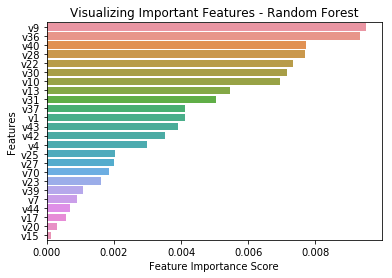

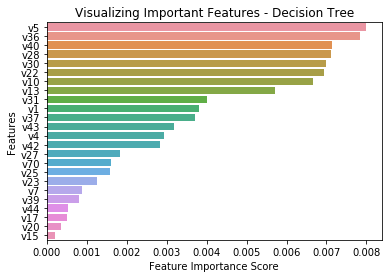

In [10]:
features = [ 'Decision Tree', 'Random Forest']
for every_m_f in feature_imp:
    sns.barplot(x=every_m_f[every_m_f.shape[0]//2:], y=every_m_f.index[every_m_f.shape[0]//2:],orient='h')
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Visualizing Important Features - {}".format(features.pop()))
    plt.show()


### Modifying model based on Importance

In [12]:
#picking top 70% of the important features
non_important_features = feature_imp[0].index.tolist()[int(feature_imp[0].shape[0]*.70):]


impt_fit = lambda x: x.fit(X_train.drop(columns = [target] + non_important_features ).values, X_train[target].values)
impt_predict = lambda x: x.predict(X_test.drop(columns = [target] + non_important_features).values)

# metrics or model evaluation
imp_prediction_metrics = [
    [X_test.shape[0], (X_test[target] != i).sum(), accuracy_score(X_test[target], i) , 
        classification_report(X_test[target], i) ]
  for i in [impt_predict(model) for model in 
            [impt_fit(method) for method in models]
           ]]
print(get_metrics(methods,imp_prediction_metrics))


--------------
MultinomialNB Method: 
--------------
	>>> Failed to predict 8290 out of 35960.
Accuracy: 76.95% 
precision recall f1-score support
    0.76   0.77     0.76   35960
--------------
BernoulliNB Method: 
--------------
	>>> Failed to predict 8514 out of 35960.
Accuracy: 76.32% 
precision recall f1-score support
    0.85   0.76     0.78   35960
--------------
GaussianNB Method: 
--------------
	>>> Failed to predict 11892 out of 35960.
Accuracy: 66.93% 
precision recall f1-score support
    0.82   0.67     0.73   35960
--------------
RandomForestClassifier Method: 
--------------
	>>> Failed to predict 4041 out of 35960.
Accuracy: 88.76% 
precision recall f1-score support
    0.88   0.89     0.88   35960
--------------
DecisionTreeClassifier Method: 
--------------
	>>> Failed to predict 4408 out of 35960.
Accuracy: 87.74% 
precision recall f1-score support
    0.87   0.88     0.87   35960


In [13]:
end = time.time()
print(' Process took {:05.2f} minutes'.format((end-global_start)/60))

 Process took 02.99 minutes
